In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

stopwords = set(stopwords.words('english'))

### Data Reading

In [2]:
train_df = pd.read_csv('../data/raw/jigsaw/train.csv')
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
test_df = pd.read_csv('../data/raw/jigsaw/test.csv')
test_labels_df = pd.read_csv('../data/raw/jigsaw/test_labels.csv')

test_df = test_df.merge(test_labels_df, how='inner', on='id')
test_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [4]:
train_df.shape, test_df.shape

((159571, 8), (153164, 8))

### Data Wrangling

In [5]:
def is_toxic(row):
    return 1 if row.sum() > 1 else -1 if row.sum() < 0 else 0

test_df['is_toxic'] = test_df.iloc[:, 2:].apply(is_toxic, axis=1)

# filter test set
test_df = test_df[test_df['is_toxic'] > -1].drop('is_toxic', axis=1)
len(test_df)

63978

In [6]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [7]:
train_df.iloc[:, 2:].sum(axis=0)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [8]:
train_df['occurrence'] = train_df.iloc[:, 2:].sum(axis=1)
test_df['occurrence'] = test_df.iloc[:, 2:].sum(axis=1)

In [9]:
train_df['clean'] = train_df['occurrence'].map(lambda x: 1 if x == 0 else 0)
train_df['multilabel'] = train_df['occurrence'].map(lambda x: 1 if x > 1 else 0)
test_df['clean'] = test_df['occurrence'].map(lambda x: 1 if x == 0 else 0)
test_df['multilabel'] = test_df['occurrence'].map(lambda x: 1 if x > 1 else 0)

display(train_df.head(2))
display(test_df.head(2))

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,occurrence,clean,multilabel
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,1,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,1,0


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,occurrence,clean,multilabel
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,0,1,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,0,1,0


In [10]:
train_df[train_df['identity_hate'] == 1].head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,occurrence,clean,multilabel
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,4,0,1
105,00472b8e2d38d1ea,A pair of jew-hating weiner nazi schmucks.,1,0,1,0,1,1,4,0,1


In [11]:
def plot_dist(x, y):
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x, y)
    plt.xlabel('Label')
    plt.ylabel('Total')

    rects = ax.patches

    for rect, count in zip(rects, y):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, count, ha='center', va='bottom')

    plt.show()

#### Toxic - Multi Toxic - Non Toxic

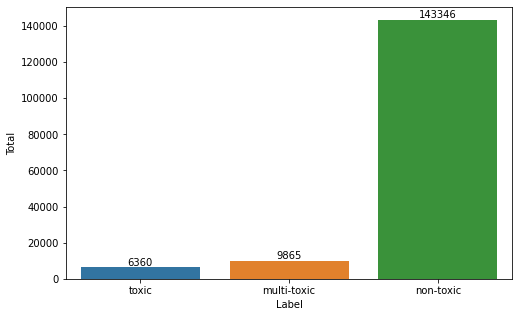

In [12]:
train_clean = train_df[train_df['clean'] == 1]['id'].count()
train_toxic_only = train_df[train_df['occurrence'] == 1]['id'].count()
train_toxic_multi = train_df[train_df['multilabel'] == 1]['id'].count()

labels = ['toxic', 'multi-toxic', 'non-toxic']
counts = [train_toxic_only, train_toxic_multi, train_clean]

plot_dist(labels, counts)

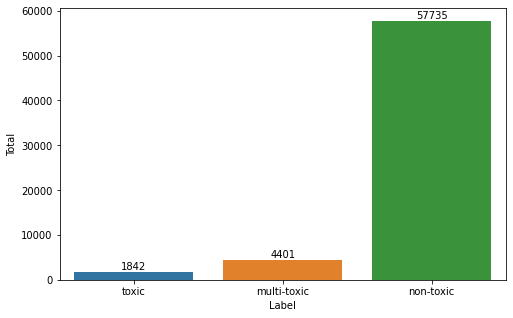

In [13]:
test_clean = test_df[test_df['clean'] == 1]['id'].count()
test_toxic_only = test_df[test_df['occurrence'] == 1]['id'].count()
test_toxic_multi = test_df[test_df['multilabel'] == 1]['id'].count()

labels = ['toxic', 'multi-toxic', 'non-toxic']
counts = [test_toxic_only, test_toxic_multi, test_clean]

plot_dist(labels, counts)

#### Toxic - Multi Toxic (in depth)

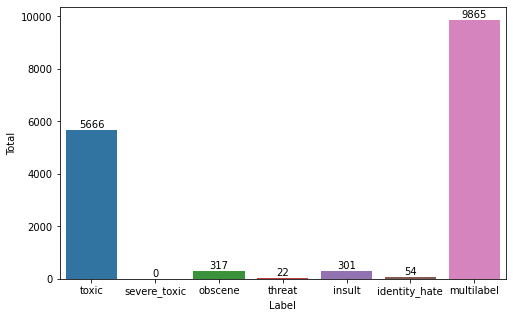

In [14]:
toxic_only_df = train_df[train_df['occurrence'] == 1].drop(['id', 'comment_text', 'occurrence', 'clean', 'multilabel'], axis=1).sum(axis=0)

labels = toxic_only_df.index.tolist()
counts = toxic_only_df.values.tolist()

# add multilabel and clean data
labels.extend(['multilabel'])
counts.extend([train_toxic_multi])

# plot
plot_dist(labels, counts)

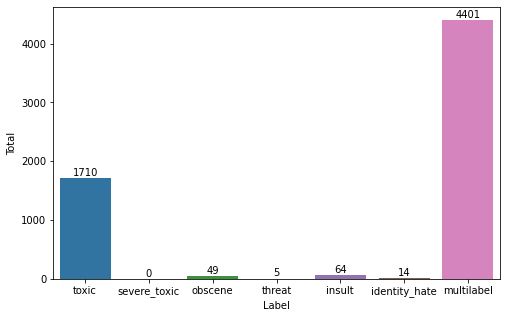

In [15]:
test_toxic_only_df = test_df[test_df['occurrence'] == 1].drop(['id', 'comment_text', 'occurrence', 'clean', 'multilabel'], axis=1).sum(axis=0)

labels = test_toxic_only_df.index.tolist()
counts = test_toxic_only_df.values.tolist()

# add multilabel and clean data
labels.extend(['multilabel'])
counts.extend([test_toxic_multi])

# plot
plot_dist(labels, counts)

#### Multi Toxic Analysis

In [16]:
train_multi_toxic = train_df[train_df['multilabel'] == 1]

# severe toxic
train_severe_neighbor = train_multi_toxic[train_multi_toxic['severe_toxic'] == 1]
train_severe_neighbor = train_severe_neighbor.iloc[:, 2:-3].sum()

In [17]:
# obscene
train_obscene_neighbor = train_multi_toxic[train_multi_toxic['obscene'] == 1]
train_obscene_neighbor = train_obscene_neighbor.iloc[:, 2:-3].sum()

In [18]:
# threat
train_threat_neighbor = train_multi_toxic[train_multi_toxic['threat'] == 1]
train_threat_neighbor = train_threat_neighbor.iloc[:, 2:-3].sum()

In [19]:
# insult
train_insult_neighbor = train_multi_toxic[train_multi_toxic['insult'] == 1]
train_insult_neighbor = train_insult_neighbor.iloc[:, 2:-3].sum()

In [20]:
# identity_hate
train_identity_hate_neighbor = train_multi_toxic[train_multi_toxic['identity_hate'] == 1]
train_identity_hate_neighbor = train_identity_hate_neighbor.iloc[:, 2:-3].sum()

In [21]:
# toxic
train_toxic_neighbor = train_multi_toxic[train_multi_toxic['toxic'] == 1]
train_toxic_neighbor = train_toxic_neighbor.iloc[:, 2:-3].sum()

In [22]:
train_toxic_neighbor

toxic            9628
severe_toxic     1595
obscene          7926
threat            449
insult           7344
identity_hate    1302
dtype: int64

In [23]:
all_neighbor = [
    train_toxic_neighbor,
    train_severe_neighbor,
    train_obscene_neighbor, 
    train_threat_neighbor,
    train_insult_neighbor,
    train_identity_hate_neighbor
]

neighbor_df = pd.DataFrame(all_neighbor, index=train_toxic_neighbor.index)
neighbor_df

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,9628,1595,7926,449,7344,1302
severe_toxic,1595,1595,1517,112,1371,313
obscene,7926,1517,8132,301,6155,1032
threat,449,112,301,456,307,98
insult,7344,1371,6155,307,7576,1160
identity_hate,1302,313,1032,98,1160,1351


In [24]:
freq_data = neighbor_df.to_numpy()
max_column = np.max(freq_data, axis=0)
freq_data

array([[9628, 1595, 7926,  449, 7344, 1302],
       [1595, 1595, 1517,  112, 1371,  313],
       [7926, 1517, 8132,  301, 6155, 1032],
       [ 449,  112,  301,  456,  307,   98],
       [7344, 1371, 6155,  307, 7576, 1160],
       [1302,  313, 1032,   98, 1160, 1351]], dtype=int64)

In [39]:
manual_mask = np.array([
    [   0, 1595, 7926,  449, 7344, 1302],
    [   0,    0, 1517,    0, 1371,    0],
    [7926, 1517,    0,  301, 6155, 1032],
    [   0,    0,    0,    0,    0,    0],
    [7344, 1371, 6155,  307,    0, 1160],
    [   0,    0,    0,    0,    0,    0]
])
manual_mask

array([[   0, 1595, 7926,  449, 7344, 1302],
       [   0,    0, 1517,    0, 1371,    0],
       [7926, 1517,    0,  301, 6155, 1032],
       [   0,    0,    0,    0,    0,    0],
       [7344, 1371, 6155,  307,    0, 1160],
       [   0,    0,    0,    0,    0,    0]])

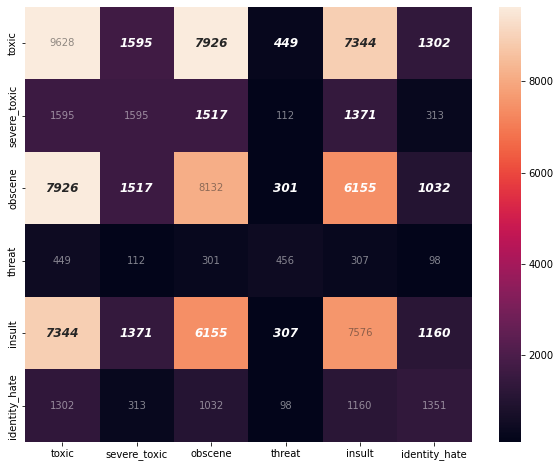

In [40]:
plt.figure(figsize=(10,8))
sns.heatmap(neighbor_df, 
        fmt='d', 
        annot=True, 
        mask=freq_data==manual_mask,
        annot_kws={'alpha': .5})
sns.heatmap(neighbor_df, 
        fmt='d', 
        annot=True, 
        mask=freq_data!=manual_mask, 
        annot_kws={'style': 'italic', 'weight': 'bold', 'fontsize': 'large'}, 
        cbar=False)
plt.show()

It can be seen that we faced imbalanced case. Almost 90% data are clean, while ~10% are dsitributed between toxic family labels. Also there are ~6% data that has more than 1 labels.

Wordcloud
===

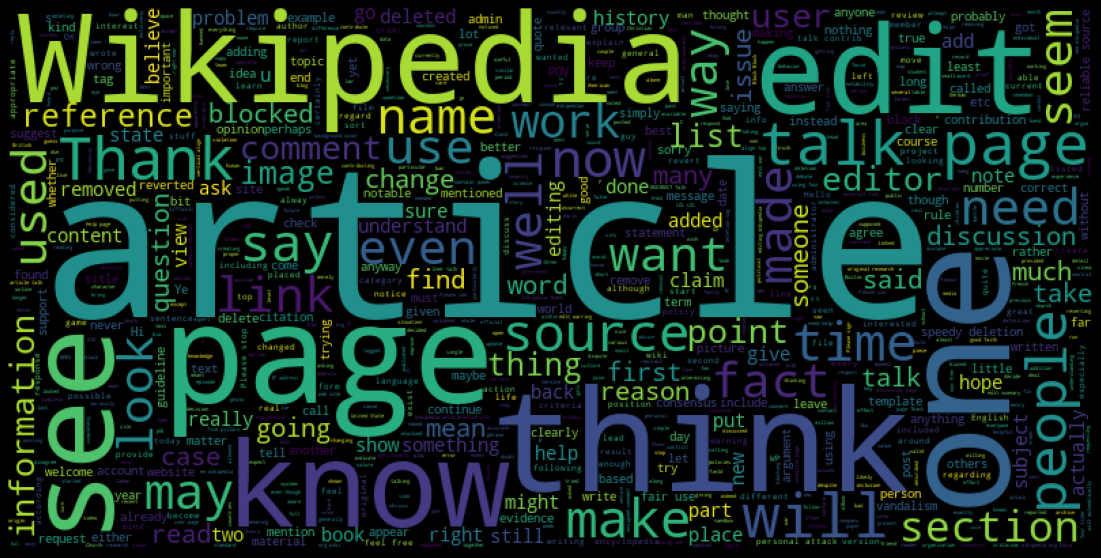

In [17]:
# stopwords
wc_stopwords = set(STOPWORDS)

# subset clean comment
clean = train_df[train_df['clean'] == 1].comment_text.values

wc = WordCloud(width=800, height=400, background_color='black', max_words=2000, stopwords=wc_stopwords)
wc_img = wc.generate(" ".join(clean))

plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wc_img)
plt.axis('off')
plt.show()

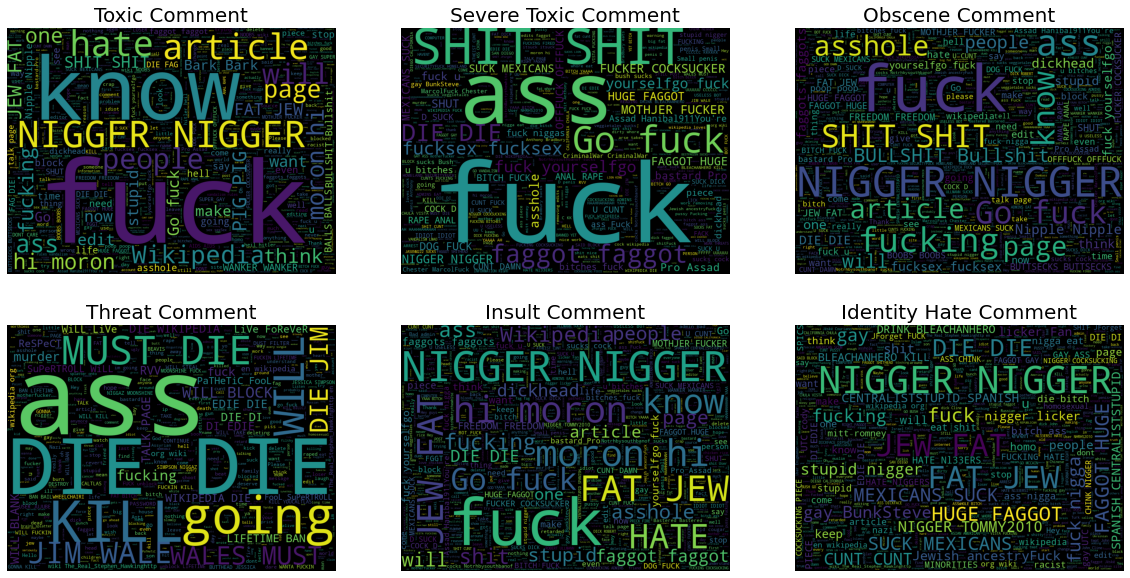

In [18]:
wc = WordCloud(width=800, height=600, background_color='black', max_words=4000, stopwords=wc_stopwords)

plt.figure(figsize=(20,10))

# wc = WordCloud(width=1200, height=800, background_color='black', max_words=2000, stopwords=wc_stopwords)

# subset toxic comment
toxic = train_df[train_df['toxic'] == 1].comment_text.values

# toxic wordcloud
wc_toxic = wc.generate(" ".join(toxic))
plt.subplot(231)
plt.axis('off')
plt.title('Toxic Comment', fontsize=20)
plt.imshow(wc_toxic)


# subset severe toxic comment
severe = train_df[train_df['severe_toxic'] == 1].comment_text.values

# severe toxic wordcloud
wc_severe = wc.generate(' '.join(severe))
plt.subplot(232)
plt.axis('off')
plt.title('Severe Toxic Comment', fontsize=20)
plt.imshow(wc_severe)


# subset obscene comment
obscene = train_df[train_df['obscene'] == 1].comment_text.values

# obscene wordcloud
wc_obscene = wc.generate(' '.join(obscene))
plt.subplot(233)
plt.axis('off')
plt.title('Obscene Comment', fontsize=20)
plt.imshow(wc_obscene)


# subset threat comment
threat = train_df[train_df['threat'] == 1].comment_text.values

# threat wordcloud
wc_threat = wc.generate(' '.join(threat))
plt.subplot(234)
plt.axis('off')
plt.title('Threat Comment', fontsize=20)
plt.imshow(wc_threat)


# subset insult comment
insult = train_df[train_df['insult'] == 1].comment_text.values

# insult wordcloud
wc_insult = wc.generate(' '.join(insult))
plt.subplot(235)
plt.axis('off')
plt.title('Insult Comment', fontsize=20)
plt.imshow(wc_insult)


# subset identity hate
identity_hate = train_df[train_df['identity_hate'] == 1].comment_text.values

# identity hate wordcloud
wc_identity_hate = wc.generate(' '.join(identity_hate))
plt.subplot(236)
plt.axis('off')
plt.title('Identity Hate Comment', fontsize=20)
plt.imshow(wc_identity_hate)

plt.show()

Feature Extraction
===

In [85]:
# keep comment text only for simplicity
df = train_df.copy()
old_column = df.columns[2:]
df.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,occurrence,clean,multilabel
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,1,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,1,0


In [86]:
df['count_sent'] = df['comment_text'].apply(lambda x: len(re.findall('\n', str(x)))+1)
df['count_word'] = df['comment_text'].apply(lambda x: len(str(x).split()))
df['count_unique_word'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))
df['count_letters'] = df['comment_text'].apply(lambda x: len(str(x)))
df['count_punct'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df['count_words_upper'] = df['comment_text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
df['count_words_title'] = df['comment_text'].apply(lambda x: len([w for w in str(x).split() if w.istitle]))
df['count_stopwords'] = df['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
df['mean_word_length'] = df['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [106]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,occurrence,clean,multilabel,count_sent,count_word,count_unique_word,count_letters,count_punct,count_words_upper,count_words_title,count_stopwords,mean_word_length
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.00000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.219952,0.898321,0.061822,3.52074,67.273527,48.097323,394.073221,15.885418,2.974206,67.273527,30.200262,4.936961
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.748260,0.302226,0.240833,5.96225,99.230702,54.436443,590.720282,36.649770,21.207633,99.230702,45.296447,7.220133
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,1.000000,6.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.00000,17.000000,16.000000,96.000000,4.000000,0.000000,17.000000,7.000000,4.330472
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.00000,36.000000,31.000000,205.000000,8.000000,1.000000,36.000000,16.000000,4.696429
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.00000,75.000000,59.000000,435.000000,17.000000,3.000000,75.000000,35.000000,5.105263
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,313.00000,1411.000000,816.000000,5000.000000,4942.000000,1352.000000,1411.000000,902.000000,1655.000000


In [107]:
# derived features
df['word_unique_percent'] = df['count_unique_word'] * 100 / df['count_word']
df['punct_percent'] = df['count_punct'] * 100 / df['count_word']

In [108]:
df_token_an = df.drop(old_column, axis=1)
df_token_an.head(3)

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punct,count_words_upper,count_words_title,count_stopwords,mean_word_length,word_unique_percent,punct_percent
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,43,18,5.162791,95.348837,23.255814
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,17,2,5.588235,100.000000,70.588235
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,42,20,4.571429,92.857143,14.285714


In [110]:
df_token_an.describe()

,count_sent,count_word,count_unique_word,count_letters,count_punct,count_words_upper,count_words_title,count_stopwords,mean_word_length,word_unique_percent,punct_percent
count,159571.00000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,3.52074,67.273527,48.097323,394.073221,15.885418,2.974206,67.273527,30.200262,4.936961,85.501925,30.130164
std,5.96225,99.230702,54.436443,590.720282,36.649770,21.207633,99.230702,45.296447,7.220133,12.817618,201.474287
min,1.00000,1.000000,1.000000,6.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.080000,0.000000
25%,1.00000,17.000000,16.000000,96.000000,4.000000,0.000000,17.000000,7.000000,4.330472,77.906977,14.814815
50%,2.00000,36.000000,31.000000,205.000000,8.000000,1.000000,36.000000,16.000000,4.696429,87.500000,21.739130
75%,3.00000,75.000000,59.000000,435.000000,17.000000,3.000000,75.000000,35.000000,5.105263,95.652174,33.159258
max,313.00000,1411.000000,816.000000,5000.000000,4942.000000,1352.000000,1411.000000,902.000000,1655.000000,100.000000,70600.000000


### Token Analysis

In [120]:
# toxic
token_an_toxic = df[df['occurrence'] == 1]
# multilabel
token_an_multi = df[df['multilabel'] == 1]

# severe
token_an_severe = token_an_toxic[token_an_toxic['severe_toxic'] == 1]
# obscene
token_an_obscene = token_an_toxic[token_an_toxic['obscene'] == 1]
# threat
token_an_threat = token_an_toxic[token_an_toxic['threat'] == 1]
# insult
token_an_insult = token_an_toxic[token_an_toxic['insult'] == 1]
# identity
token_an_identity = token_an_toxic[token_an_toxic['identity_hate'] == 1]
# toxic
token_an_toxic = token_an_toxic[token_an_toxic['toxic'] == 1]

In [132]:
print('toxic')
display(token_an_toxic[['count_word', 'count_unique_word', 'word_unique_percent']].describe())
print('obscene')
display(token_an_obscene[['count_word', 'count_unique_word', 'word_unique_percent']].describe())
print('threat')
display(token_an_threat[['count_word', 'count_unique_word', 'word_unique_percent']].describe())
print('insult')
display(token_an_insult[['count_word', 'count_unique_word', 'word_unique_percent']].describe())
print('identity')
display(token_an_identity[['count_word', 'count_unique_word', 'word_unique_percent']].describe())
print('multi')
display(token_an_multi[['count_word', 'count_unique_word', 'word_unique_percent']].describe())

toxic


,count_word,count_unique_word,word_unique_percent
count,5666.000000,5666.000000,5666.000000
mean,58.985704,39.858630,87.074782
std,105.458715,46.727963,14.752096
min,2.000000,1.000000,0.080000
25%,14.000000,13.000000,80.834581
50%,29.000000,25.000000,90.000000
75%,60.000000,48.750000,100.000000
max,1411.000000,461.000000,100.000000


obscene


,count_word,count_unique_word,word_unique_percent
count,317.000000,317.000000,317.000000
mean,94.697161,64.548896,82.716290
std,132.289730,68.913781,14.189602
min,3.000000,3.000000,3.125000
25%,24.000000,22.000000,76.315789
50%,52.000000,44.000000,84.615385
75%,108.000000,80.000000,92.307692
max,846.000000,437.000000,100.000000


threat


,count_word,count_unique_word,word_unique_percent
count,22.000000,22.000000,22.000000
mean,34.772727,27.681818,84.983698
std,33.353706,23.759482,12.716713
min,6.000000,6.000000,46.428571
25%,17.500000,13.750000,76.117647
50%,24.500000,20.500000,88.326586
75%,36.250000,27.750000,92.230769
max,153.000000,111.000000,100.000000


insult


,count_word,count_unique_word,word_unique_percent
count,301.000000,301.000000,301.000000
mean,57.906977,43.571429,87.067127
std,69.693553,39.517157,11.587979
min,3.000000,3.000000,0.943396
25%,17.000000,16.000000,80.555556
50%,35.000000,31.000000,88.888889
75%,73.000000,60.000000,95.454545
max,636.000000,278.000000,100.000000


identity


,count_word,count_unique_word,word_unique_percent
count,54.000000,54.000000,54.000000
mean,88.592593,62.777778,85.087585
std,132.479050,73.460467,12.952485
min,5.000000,5.000000,50.845411
25%,16.000000,14.500000,74.836957
50%,42.500000,37.500000,86.190476
75%,103.750000,78.750000,96.849798
max,828.000000,421.000000,100.000000


multi


,count_word,count_unique_word,word_unique_percent
count,9865.000000,9865.000000,9865.000000
mean,47.454029,27.940193,88.031959
std,107.107932,34.576028,17.490549
min,2.000000,1.000000,0.100000
25%,10.000000,9.000000,83.333333
50%,20.000000,17.000000,92.307692
75%,42.000000,34.000000,100.000000
max,1403.000000,480.000000,100.000000


In [133]:
token_an_toxic[token_an_toxic['word_unique_percent'] == token_an_toxic.word_unique_percent.min()]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,occurrence,clean,...,count_word,count_unique_word,count_letters,count_punct,count_words_upper,count_words_title,count_stopwords,mean_word_length,word_unique_percent,punct_percent
32143,5572234220e43ea2,PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PI...,1,0,0,0,0,0,1,0,...,1250,1,4999,0,1250,1250,0,3.0,0.08,0.0


In [144]:
token_an_toxic[token_an_toxic['word_unique_percent'] <= token_an_toxic.word_unique_percent.quantile(.01)][['comment_text', 'count_word', 'word_unique_percent']].head()

,comment_text,count_word,word_unique_percent
6572,Sex sex sex sex Sex sex sex sexSex sex sex sex...,1001,0.299700
7183,aryour retarded your retarded your retarded yo...,77,5.194805
8705,BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALL...,834,0.239808
18490,7>STOP EDITING MY POSTS DIPSHIT \nI HAVE A RIG...,775,3.483871
20698,User:Edgar181 is a shit.\nUser:Edgar181 is a s...,260,1.538462


In [145]:
token_an_multi[token_an_multi['word_unique_percent'] <= token_an_multi.word_unique_percent.quantile(.01)][['comment_text', 'count_word', 'word_unique_percent']].head()

,comment_text,count_word,word_unique_percent
2249,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A...,468,1.282051
2420,FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT ...,1087,0.459982
5220,HATE YOU HATE YOU HATE YOU HATE YOU HATE YOU H...,1108,0.451264
5523,Go fuck yourself! Go fuck yourself! Go fuck yo...,831,0.361011
6201,SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SE...,455,0.659341


In [157]:
display(token_an_toxic[token_an_toxic['word_unique_percent'] == token_an_toxic.word_unique_percent.min()][['comment_text', 'count_word', 'word_unique_percent', 'clean']].sort_values(by=['count_word'], ascending=False))


,comment_text,count_word,word_unique_percent,clean
32143,PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PI...,1250,0.08,0


In [159]:
display(token_an_multi[token_an_multi['word_unique_percent'] == token_an_multi.word_unique_percent.min()][['comment_text', 'count_word', 'word_unique_percent', 'clean']].sort_values(by=['count_word'], ascending=False).head())
token_an_multi[token_an_multi['word_unique_percent'] == token_an_multi.word_unique_percent.min()]['comment_text'].values

,comment_text,count_word,word_unique_percent,clean
87454,SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT S...,1000,0.1,0


array(['SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SH

In [161]:
display(token_an_obscene[token_an_obscene['word_unique_percent'] == token_an_obscene.word_unique_percent.min()][['comment_text', 'count_word', 'word_unique_percent', 'clean']].sort_values(by=['count_word'], ascending=False).head())
token_an_obscene[token_an_obscene['word_unique_percent'] == token_an_obscene.word_unique_percent.min()]['comment_text'].values

,comment_text,count_word,word_unique_percent,clean
134959,PHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OF...,224,3.125,0


array(['PHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB OF CHEESE!\n\nSALT!\nPHUQ OFF YOU KNOB

In [162]:
display(token_an_insult[token_an_insult['word_unique_percent'] == token_an_insult.word_unique_percent.min()][['comment_text', 'count_word', 'word_unique_percent', 'clean']].sort_values(by=['count_word'], ascending=False).head())
token_an_insult[token_an_insult['word_unique_percent'] == token_an_insult.word_unique_percent.min()]['comment_text'].values

,comment_text,count_word,word_unique_percent,clean
140930,Repeat: Daedalus969 is a biznitch \nRepeat: Da...,636,0.943396,0


array(['Repeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch Repeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch Repeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch Repeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch Repeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch Repeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch Repeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitch \nRepeat: Daedalus969 is a biznitc

In [14]:
# subset of labels
train_labels = train_df.iloc[:, 2:]

# merge into single dataframe
train_features = pd.concat([df, train_labels], axis=1)

train_features.head()

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punct,count_words_upper,count_words_title,count_stopwords,...,punct_percent,toxic,severe_toxic,obscene,threat,insult,identity_hate,occurrence,clean,multilabel
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,43,18,...,23.255814,0,0,0,0,0,0,0,1,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,17,2,...,70.588235,0,0,0,0,0,0,0,1,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,42,20,...,14.285714,0,0,0,0,0,0,0,1,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,21,5,113,56,...,18.584071,0,0,0,0,0,0,0,1,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,5,0,13,5,...,38.461538,0,0,0,0,0,0,0,1,0


## Mutual Information Analysis

In [52]:
from sklearn.feature_selection import mutual_info_classif

predictor = train_features.iloc[:, 2:13]
target = train_features.iloc[:, 13]

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_series = pd.Series(mi_scores, index=X.columns)
    # mi_series = mi_series.sort_values(ascending=False)

    return mi_series

In [59]:
scores = make_mi_scores(predictor, target)
scores = scores.sort_values(ascending=False)
scores

mean_word_length       0.014056
count_punct            0.013304
punct_percent          0.012941
word_unique_percent    0.012605
count_letters          0.011201
count_unique_word      0.011055
count_words_upper      0.009715
count_stopwords        0.009685
count_word             0.009665
count_words_title      0.008589
count_sent             0.006867
dtype: float64

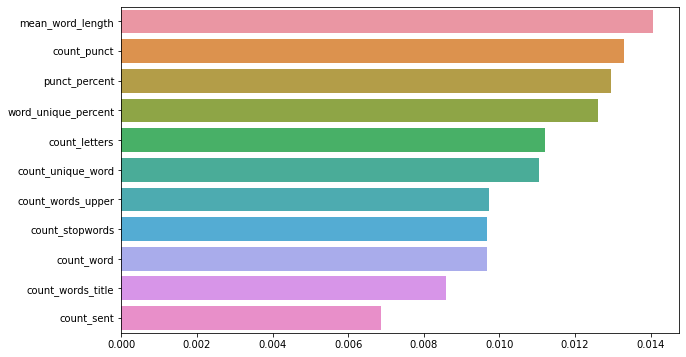

In [60]:
plt.figure(figsize=(10,6))
sns.barplot(x=scores, y=scores.index)
plt.show()

## Feature Importance with XGBoost

In [65]:
target.unique()

array([0, 1])

In [72]:
from xgboost import XGBClassifier, plot_importance

xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(predictor, target)

[08:33:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [73]:
print(xgb.feature_importances_)

[0.08823949 0.04974879 0.10784478 0.10823794 0.06479447 0.23913749
 0.         0.06485992 0.08697797 0.09737987 0.09277926]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

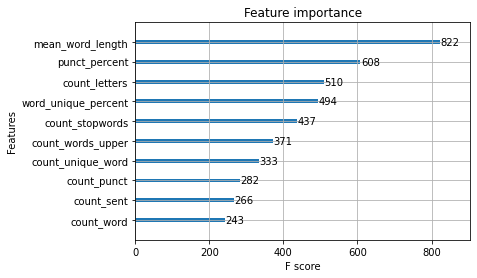

In [74]:
plot_importance(xgb)